<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Classes" data-toc-modified-id="Neural-Network-Classes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Classes</a></span></li><li><span><a href="#Additional-Required-Functions" data-toc-modified-id="Additional-Required-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Additional Required Functions</a></span></li><li><span><a href="#Application-to-Three-Data-Sets" data-toc-modified-id="Application-to-Three-Data-Sets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Application to Three Data Sets</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

<font size=10>Neural Networks in Pytorch</font>

In this assignment, you will
1. complete the implementations of neural network classes,
2. define the new function `multiple_runs_classification`,
3. define the new function `multiple_runs_convolutional`,
4. copy and paste `percent_correct` and `confusion_matrx` from previous notes,
4. present and discuss regression results on automobile MPG data,
5. present and discuss classification results on diabetes data,
6. present and discuss classification results on small version of MNIST data.

# Neural Network Classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

For this assignment, start with implementations of the following classes:
* `NeuralNetworkTorch`: copied and pasted from Lecture Notes 16.1
* `NeuralNetworkClassifierTorch`: copied and pasted from Lecture Notes 16.1
* `NeuralNetworkClassifierConvolutionalTorch`: copied and pasted from Lecture Notes 16.1 and completed.

The `train` functions in this classes have two additional arguments, `Xval`nad `Tval`:

```python
   def train(self, Xtrain, Ttrain, n_epochs, learning_rate=0.01, method='adam', verbose=True, 
             Xval=None, Tval=None):
```

where `Xtrain` and `Ttrain` are the usual two arguments used to train the network, and `Xval` and `Tval` are the validation data matrices.  `Xval` and `Tval` are only used to calculate the performance (MSE or NLL) once per epoch.  If the performance is better than the best so far, update an array that is storing the best weight values so far, and also update the best performance so far.  When training is complete, copy the stored best-so-far weights back into the network.  If `Xval` is `None`, then this step is ignored and the weights in the neural network at the end of training are not modified.

In [2]:
######################################################################
## NeuralNetwork  for regression
######################################################################

class NeuralNetworkTorch(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, device='cpu'):

        super().__init__()

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.device = device

        self.n_layers = len(n_hiddens_list) + 1
        
        self.layers = torch.nn.ModuleList()
        for n_units in n_hiddens_list:
            self.layers.append(self._make_tanh_layer(n_inputs, n_units))
            n_inputs = n_units
        self.layers.append(torch.nn.Linear(n_inputs, n_outputs))

        self.stand_params = None
        self.error_trace = []
        self.error_trace_val = []

    def _make_tanh_layer(self, n_inputs, n_units):
        return torch.nn.Sequential(torch.nn.Linear(n_inputs, n_units),
                                   torch.nn.Tanh())

    def __repr__(self):
        return f'NeuralNetworkTorch({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, device={self.device})'

    def forward(self, Xst):
        Ys = [Xst]
        for layer in self.layers:
            Ys.append(layer(Ys[-1]))
        return Ys[1:]  # remove X from Ys

    def train(self, Xtrain, Ttrain, n_epochs=10, learning_rate=0.01, method='adam', verbose=True, Xval=None, Tval=None):

        if isinstance(Xtrain, np.ndarray):
            Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
        if isinstance(Ttrain, np.ndarray):
            Ttrain = torch.from_numpy(Ttrain.astype(np.float32))

        if Xval is not None:
            if isinstance(Xval, np.ndarray):
                Xval = torch.from_numpy(Xval.astype(np.float32))
            if isinstance(Tval, np.ndarray):
                Tval = torch.from_numpy(Tval.astype(np.float32))

        self.stand_params = self.calc_standardize_parameters(Xtrain, Ttrain)
        Xtrain = self.standardize_X(Xtrain)
        Ttrain = self.standardize_T(Ttrain)
        if Xval is not None:
            Xval = self.standardize_X(Xval)
            Tval = self.standardize_T(Tval)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            print('train: method must be \'sgd\', or \'adam\'.')

        error_f = torch.nn.MSELoss()

        self.best_epoch = None
        best_mse = None
        best_weights = self.get_all_weights()
        
        for epoch in range(n_epochs):

            Ytrain = self.forward(Xtrain)[-1]  # to get last layer output
            mse = error_f(Ytrain, Ttrain)

            optimizer.zero_grad()
            mse.backward()
            optimizer.step()

            self.error_trace.append(mse.sqrt())
            
            if Xval is not None:
                Yval = self.forward(Xval)[-1]
                mse_val = error_f(Yval, Tval)
                self.error_trace_val.append(mse_val.sqrt())
                
                if best_mse is None or mse_val < best_mse:
                    best_mse = mse_val
                    best_weights = self.get_all_weights()
                    self.best_epoch = epoch

            if verbose and ((epoch+1) % (n_epochs // 10) == 0 or epoch == n_epochs - 1):
                if Xval is not None:
                    print(f'Epoch {epoch+1} RMSE train {self.error_trace[-1]:.4f} val {self.error_trace_val[-1]:.4f}')
                else:
                    print(f'Epoch {epoch+1} RMSE {self.error_trace[-1]:.4f}')
                
        if Xval is not None:
            self.set_all_weights(best_weights)

        return self

    def use(self, X, return_hidden_layer_outputs=False):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))

        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        Y = Y.detach().cpu().numpy()
        Zs = [Z.detach().cpu().numpy() for Z in Zs]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def get_error_traces(self):
        return self.error_trace, self.error_trace_val, self.best_epoch

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = Xstds[Xstds > 0].mean(axis=0)
        if T is None:
            return {'Xmeans': Xmeans, 'Xstds': Xstds}
        else:
            Tmeans = T.mean(axis=0)
            Tstds = T.std(axis=0)
            return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

    def get_Ws(self):
        Ws = []
        for layer in self.layers:
            W_and_bias = list(layer.parameters())
            W = W_and_bias[0].detach().numpy()
            Wbias = W_and_bias[1].detach().numpy().T.reshape(1, -1)
            if W.ndim == 4:
                W = np.moveaxis(W, 0, 3)  # first dim is units. Move it to last, fourth, dim
                n_units = Wbias.shape[-1]
                W = W.reshape(-1, n_units)
            else:
                W = W.T
            Ws.append(np.vstack((Wbias, W)))
        return Ws
        
    def get_all_weights(self):
        return torch.nn.utils.parameters_to_vector(self.parameters())

    def set_all_weights(self, all_weights):
        torch.nn.utils.vector_to_parameters(all_weights, self.parameters())

In [3]:
######################################################################
## NeuralNetworkClassifierTorch
######################################################################

class NeuralNetworkClassifierTorch(NeuralNetworkTorch):

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, device='cpu'):

        if isinstance(n_inputs, list) or isinstance(n_inputs, tuple):
            # n_inputs might be n_channels, n_rows, n_cols in 2-d input sample
            # if defined for use in a Convolutional network
            super().__init__(np.prod(n_inputs), n_hiddens_list, n_outputs, device)
        else:
            super().__init__(n_inputs, n_hiddens_list, n_outputs, device)

        last_layer = self.layers[-1]
        new_last_layer = torch.nn.Sequential(last_layer,
                                             torch.nn.LogSoftmax(dim=1))  # across columns
        self.layers = self.layers[:-1]
        self.layers.append(new_last_layer)
        # self.layers = self.layers[:-1] + new_last_layer

    def __repr__(self):
        return f'NeuralNetworkClassifierTorch({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, device={self.device})'

    def train(self, Xtrain, Ttrain, n_epochs=10, learning_rate=0.01, method='adam', verbose=True, Xval=None, Tval=None):

        if isinstance(Xtrain, np.ndarray):
            Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
        if isinstance(Ttrain, np.ndarray):
            Ttrain = torch.from_numpy(Ttrain.astype(np.float32))

        if Xval is not None:
            if isinstance(Xval, np.ndarray):
                Xval = torch.from_numpy(Xval.astype(np.float32))
            if isinstance(Tval, np.ndarray):
                Tval = torch.from_numpy(Tval.astype(np.float32))

        Ttrain = Ttrain.long().reshape(-1)  # pytorch expects 1D tensor as labels
        if Xval is not None:
            Tval = Tval.long().reshape(-1)
        
        self.stand_params = self.calc_standardize_parameters(Xtrain, None)
        Xtrain = self.standardize_X(Xtrain)
        if Xval is not None:
            Xval = self.standardize_X(Xval)

        self.classes, counts = Ttrain.unique(return_counts=True)
        self.classes = self.classes.numpy()
        # self.most_common_class = self.classes[np.argmax(counts)]  # not used

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            print('train: method must be \'sgd\', or \'adam\'.')

        neg_log_likelihood = torch.nn.NLLLoss()

        self.best_epoch = None
        best_nll = None
        best_weights = self.get_all_weights()
        
        for epoch in range(n_epochs):

            Ytrain = self.forward(Xtrain)[-1]  # to get last layer output as log(softmax(Y))
            nll = neg_log_likelihood(Ytrain, Ttrain)

            optimizer.zero_grad()
            nll.backward()
            optimizer.step()

            self.error_trace.append((-nll).exp())
            
            if Xval is not None:
                Yval = self.forward(Xval)[-1]
                nll_val = neg_log_likelihood(Yval, Tval)
                self.error_trace_val.append((-nll_val).exp())
                
                if best_nll is None or nll_val < best_nll:
                    best_nll = nll_val
                    best_weights = self.get_all_weights()
                    # print(f'epoch {epoch} first w {best_weights[0]}, nll train {self.error_trace[-1]} val {self.error_trace_val[-1]}')
                    self.best_epoch = epoch

            if verbose and ((epoch+1) % (n_epochs // 10) == 0 or epoch == n_epochs - 1):
                if Xval is not None:
                    print(f'Epoch {epoch+1} LL train {self.error_trace[-1]:.4f} val {self.error_trace_val[-1]:.4f}')
                else:
                    print(f'Epoch {epoch+1} NLL {self.error_trace[-1]:.4f}')

        if Xval is not None:
            # print(f'done epoch {epoch} first w {self.get_all_weights()[0]}')
            self.set_all_weights(best_weights)
            # print(f'after done epoch {epoch} first w {self.get_all_weights()[0]}')

        return self

    def use(self, X, return_hidden_layer_outputs=False):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))

        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Zs = Ys[:-1]
        probs = Y.detach().exp().cpu().numpy()  # ex() because net output is log(softmax())
        Zs = [Z.detach().cpu().numpy() for Z in Zs]
        classes = self.classes[np.argmax(probs, axis=1)].reshape(-1, 1)
        return (classes, probs, Zs) if return_hidden_layer_outputs else (classes, probs)

In [34]:
######################################################################
## NeuralNetworkClassifierConvolutionalTorch
######################################################################

class NeuralNetworkClassifierConvolutionalTorch(NeuralNetworkClassifierTorch):

    def __init__(self, n_inputs, n_conv_list, n_fc_list, n_outputs, device='cpu'):
        '''n_inputs: n_channels X n_rows X n_cols
n_conv_list: list of tuples of (n_units, kernel_size, stride)'''

        # Call constructor, but will discard the layers made and make new ones
        super().__init__(n_inputs, n_fc_list, n_outputs, device)

        self.n_channels, self.n_input_rows, self.n_input_cols = n_inputs
        self.n_conv_list = n_conv_list
        self.n_fc_list = n_fc_list
        self.n_outputs = n_outputs
        self.device = device

        self.layers = torch.nn.ModuleList()
        n_in_channels = self.n_channels
        
        output_rows, output_cols, output_channels = self.n_input_rows, self.n_input_cols, self.n_channels 
        
        for conv in n_conv_list:
            n_units, kernel_size, stride = conv
            (kernel_rows, kernel_cols) = (kernel_size, kernel_size) if np.isscalar(kernel_size) else kernel_size
            (stride_rows, stride_cols) = (stride, stride) if np.isscalar(stride) else stride

            self.layers.append(self._make_conv_layer(n_in_channels, n_units, kernel_size, stride))
            n_in_channels = n_units

            output_rows, output_cols, output_channels = (((output_rows - kernel_rows) // stride_rows) + 1), (((output_cols - kernel_cols) // stride_cols) + 1), n_units
            
        # Add Flatten to output of last convolutional layer
        self.layers[-1].add_module('flatten', torch.nn.Flatten())
        
        # Calculate the total number of inputs entering each unit in the first fully-connected layer
        n_inputs = output_rows*output_cols*output_channels

        for n_units in n_fc_list:
            self.layers.append(self._make_tanh_layer(n_inputs, n_units))
            n_inputs = n_units
            
        self.layers.append(torch.nn.Sequential(torch.nn.Linear(n_inputs, n_outputs),
                                               torch.nn.LogSoftmax(dim=1)))  # across columns

    def _make_conv_layer(self, n_in_channels, n_units, kernel_size, stride):
        return torch.nn.Sequential(torch.nn.Conv2d(n_in_channels, n_units, kernel_size, stride),
                                   torch.nn.Tanh())

    def __repr__(self):
        return f'''NeuralNetworkClassifierConvolutionalTorch(n_inputs={self.n_inputs}, n_conv_list={self.n_conv_list}, n_fc_list={self.n_fc_list}, n_outputs={self.n_outputs}, device={self.device})'''

# Additional Required Functions

Include in this notebook the following functions we have defined before
* `percent_correct`
* `partition`
* `multiple_runs_regression`

and define two new functions
* `multiple_runs_classification`
* `multiple_runs_convolutional`

based on `multiple_runs_regression`.

In [5]:
def percent_correct(Y, T):
    return np.mean(Y == T) * 100

In [6]:
def partition(X, T, fractions, shuffle=True, classification=False):
    """Usage: Xtrain,Train,Xvalidate,Tvalidate,Xtest,Ttest = partition(X,T,(0.6,0.2,0.2),classification=True)
      X is nSamples x nFeatures.
      fractions can have just two values, for partitioning into train and test only
      If classification=True, T is target class as integer. Data partitioned
        according to class proportions.
        """
    train_fraction = fractions[0]
    if len(fractions) == 2:
        # Skip the validation step
        validate_fraction = 0
        test_fraction = fractions[1]
    else:
        validate_fraction = fractions[1]
        test_fraction = fractions[2]
        
    row_indices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(row_indices)
    
    if not classification:
        # regression, so do not partition according to targets.
        n = X.shape[0]
        n_train = round(train_fraction * n)
        n_validate = round(validate_fraction * n)
        n_test = round(test_fraction * n)
        if n_train + n_validate + n_test > n:
            n_test = n - n_train - n_validate
        Xtrain = X[row_indices[:n_train], :]
        Ttrain = T[row_indices[:n_train], :]
        if n_validate > 0:
            Xvalidate = X[row_indices[n_train:n_train + n_validate], :]
            Tvalidate = T[row_indices[n_train:n_train + n_validate], :]
        Xtest = X[row_indices[n_train + n_validate:n_train + n_validate + n_test], :]
        Ttest = T[row_indices[n_train + n_validate:n_train + n_validate + n_test], :]
        
    else:
        # classifying, so partition data according to target class
        classes = np.unique(T)
        train_indices = []
        validate_indices = []
        test_indices = []
        for c in classes:
            # row indices for class c
            rows_this_class = np.where(T[row_indices,:] == c)[0]
            # collect row indices for class c for each partition
            n = len(rows_this_class)
            n_train = round(train_fraction * n)
            n_validate = round(validate_fraction * n)
            n_test = round(test_fraction * n)
            if n_train + n_validate + n_test > n:
                n_test = n - n_train - n_validate
            train_indices += row_indices[rows_this_class[:n_train]].tolist()
            if n_validate > 0:
                validate_indices += row_indices[rows_this_class[n_train:n_train + n_validate]].tolist()
            test_indices += row_indices[rows_this_class[n_train + n_validate:n_train + n_validate + n_test]].tolist()
        Xtrain = X[train_indices, :]
        Ttrain = T[train_indices, :]
        if n_validate > 0:
            Xvalidate = X[validate_indices, :]
            Tvalidate = T[validate_indices, :]
        Xtest = X[test_indices, :]
        Ttest = T[test_indices, :]
    if n_validate > 0:
        return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest
    else:
        return Xtrain, Ttrain, Xtest, Ttest

In [7]:
def multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate):
    
    def rmse(Y, T):
        return np.sqrt(np.mean((T - Y) ** 2))

    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=False)
        
        nnet = NeuralNetworkTorch(X.shape[1], n_hiddens_list, T.shape[1])
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        
        Ytrain = nnet.use(Xtrain)
        Yval = nnet.use(Xval)
        Ytest = nnet.use(Xtest)
        
        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', rmse(Ytrain, Ttrain)],
                        [structure, 'validation', rmse(Yval, Tval)],
                        [structure, 'test', rmse(Ytest, Ttest)]])
    print()
    return results

In [8]:
def multiple_runs_classification(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate):
    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=False)
        #print("Declaring NNClassifier \n")
        nnet = NeuralNetworkClassifierTorch(X.shape[1], n_hiddens_list, np.unique(T).size)
        #print("Training NNClassifier \n")
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        #print("Finished training NNClassifier \n")

        Ytrain = nnet.use(Xtrain)[0]
        Yval = nnet.use(Xval)[0]
        Ytest = nnet.use(Xtest)[0]
        
        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', percent_correct(Ytrain, Ttrain)],
                        [structure, 'validation', percent_correct(Yval, Tval)],
                        [structure, 'test', percent_correct(Ytest, Ttest)]])

        #print(percent_correct(Ytrain, Ttrain))
    print()
    return results

In [35]:
def multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, n_hiddens_list, n_epochs, learning_rate):
    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=False)
                                                                                                                                                                  
        nnet = NeuralNetworkClassifierConvolutionalTorch(X[0].shape, nconv, n_hiddens_list, np.unique(T).size)
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)

        Ytrain = nnet.use(Xtrain)[0]
        Yval = nnet.use(Xval)[0]
        Ytest = nnet.use(Xtest)[0]
        
        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', percent_correct(Ytrain, Ttrain)],
                        [structure, 'validation', percent_correct(Yval, Tval)],
                        [structure, 'test', percent_correct(Ytest, Ttest)]])

    print()
    return results

Here is another function that you must use to analyze the performance for your two classification problems.

In [20]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")
    print(f'Percent Correct is {percent_correct(Y_classes, T)}')
    return conf_matrix

Here are examples of running `multiple_runs_classification` and `multiple_runs_convolutional`.

In [32]:
def makeImages(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
        T = np.zeros((nEach * 2, 1))
        T[nEach:] = 1
    return images, T

nEach = 500
X, T = makeImages(nEach)
Xflat = X.reshape(X.shape[0], -1)
Xflat.shape, T.shape

((1000, 400), (1000, 1))

In [22]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    results.extend(multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent_Correct'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 


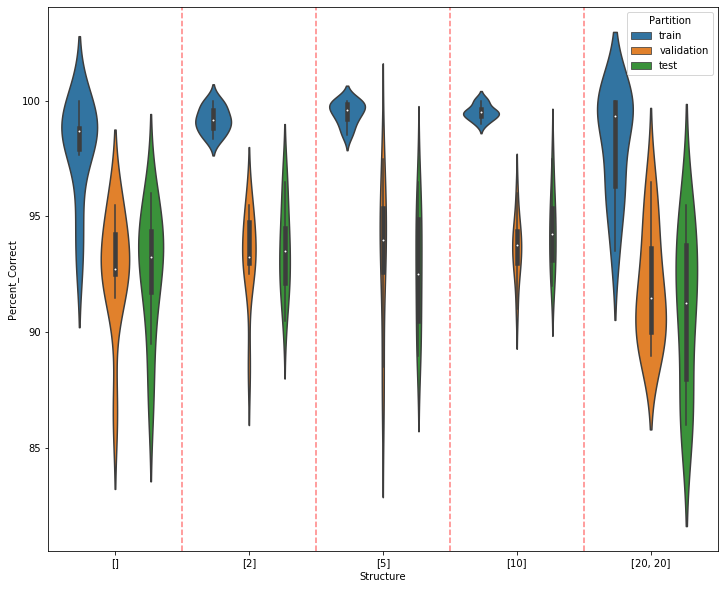

In [24]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent_Correct', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Based on results in violin plots, pick best network structure (according to performance in validation data) and train a network using that structure.  Then apply the trained network using `nnet.use` on the training, validation and testing partitions.  Report the performance of each, and, for classification problems, show the confusion matrices.  See examples below.

In [7]:
nnet = NeuralNetworkClassifierTorch(Xflat.shape[1], [10], len(np.unique(T)))
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(Xflat, T, (0.6, 0.2, 0.2),
                                         shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 50 LL train 0.9950 val 0.8856
Epoch 100 LL train 0.9983 val 0.8740
Epoch 150 LL train 0.9990 val 0.8687
Epoch 200 LL train 0.9993 val 0.8653
Epoch 250 LL train 0.9994 val 0.8621
Epoch 300 LL train 0.9995 val 0.8592
Epoch 350 LL train 0.9996 val 0.8565
Epoch 400 LL train 0.9997 val 0.8540
Epoch 450 LL train 0.9997 val 0.8517
Epoch 500 LL train 0.9998 val 0.8496


NeuralNetworkClassifierTorch(400, [10], 2, device=cpu)

In [8]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 100.0


,0.0,1.0
0.0,100.0,0.0
1.0,0.0,100.0


In [9]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 97.0


,0.0,1.0
0.0,96.0,4.0
1.0,2.0,98.0


In [10]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 95.5


,0.0,1.0
0.0,92.0,8.0
1.0,1.0,99.0


In [38]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))

Structure []: Repetition 1 (1, 20, 20)
2 (1, 20, 20)
3 (1, 20, 20)


KeyboardInterrupt: 

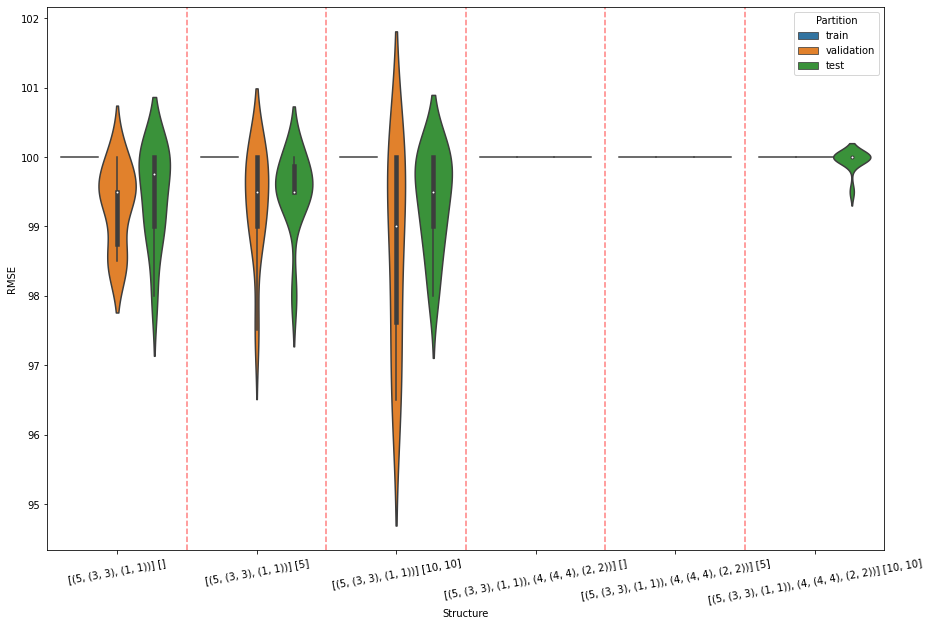

In [12]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Application to Three Data Sets

In the following experiments, you may try a variety of learning_rates, numbers of epochs, and network structures, but in the violin plot use one value for learning_rate, one value for number of epochs, and six values of network structure.

Apply `multiple_runs_regression` for various network structures to the automobile data introduced in Lecture Notes 17.  Load it as follows.

In [13]:
import pandas as pd
import os

if os.path.isfile('automobile.csv'):
    print('Reading data from \'automobile.csv\'.')
    automobile = pd.read_csv('automobile.csv')
else:
    print('Downloading auto-mpg.data from UCI ML Repository.')
    automobile = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',
                             header=None, delimiter='\s+', na_values='?', 
                             usecols=range(8))
    automobile.columns = ('mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                          'acceleration', 'year', 'origin')

    print(f'Number rows in original data file {len(automobile)}.')
    automobile = automobile.dropna(axis=0)
    print(f'Number rows after dropping rows with missing values {len(automobile)}.')
    automobile.to_csv('automobile.csv', index=False)  # so row numbers are not written to file

Number rows in original data file 398.
Number rows after dropping rows with missing values 392.


Apply `multiple_runs_classification` for various network structures to the following data set from a study in diabetes diagnosis.

In [17]:
if os.path.isfile('diabetes.csv'):
    print('Reading data from \'diabetes.csv\'.')
    diabetes = pd.read_csv('diabetes.csv')
else:
    print('Downloading diabetes_data_upload.csv from UCI ML Repository.')
    diabetes = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv')
                        # usecols=range(1,14))
    if False:
        print(f'Number rows in original data file {len(diabetes)}.')
        diabetes = diabetes.dropna(axis=0)
        print(f'Number rows after dropping rows with missing values {len(diabetes)}.')
    converter = dict(Yes=1, No=0, Female=1, Male=0, Positive=1, Negative=0)
    diabetes = diabetes.applymap(lambda x: converter.get(x, x))
    diabetes.to_csv('diabetes.csv', index=False)  # so row numbers are not written to file

X = diabetes.iloc[:, :-1].values
T = diabetes.iloc[:, -1:].values

X.shape, T.shape

((520, 16), (520, 1))

Apply `multiple_runs_convolutional` for various network structures to the following small subset of the MNIST data that contains 500 samples of each digit.

In [16]:
if os.path.isfile('small_mnist.npy'):
    print('Reading data from \'small_mnist.npz\'.')
    small_mnist = np.load('small_mnist.npz')
else:
    import shlex
    import subprocess
    print('Downloading small_mnist.npz from CS545 site.')
    cmd = 'curl "https://www.cs.colostate.edu/~anderson/cs545/notebooks/small_mnist.npz" -o "small_mnist.npz"'
    subprocess.call(shlex.split(cmd))
    small_mnist = np.load('small_mnist.npz')


X = small_mnist['X']
X = X.reshape(-1, 1, 28, 28)
T = small_mnist['T']

X.shape, T.shape

((1000, 1, 28, 28), (1000, 1))

For each of the three applications, make violin plots.  For classification problems, also show the confusion matrices.  Describe the results you see with at least 10 sentences for each application, for a total of at least 30 sentences.

# Grading

Download [A5grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.tar), extract `A5grader.py` before running the following cell.

In [1]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Ridgeway-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: Function named 'rmse' is not defined
  Check the spelling and capitalization of the function name.
CRITICAL ERROR: Function named 'multiple_runs_classifiation' is not defined
  Check the spelling and capitalization of the function name.
CRITICAL ERROR: Function named 'train_for_best_validation' is not defined
  Check the spelling and capitalization of the function name.

## Testing constructor ####################################################################

    nnet = NeuralNetworkClassifierConvolutionalTorch([1, 10, 10], 
                                                     [(2, (3, 3), (1, 1)), (3, (5, 5), (2, 2))],
                                                     [30, 20], 2)

    # Is isinstance(nnet, NeuralNetworkClassi